In [31]:
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [110]:
def image_sample(Img, x, y, cval=0):
    shape = list(Img.shape)
    shape[0] += 1
    shape[1] += 1
    img = np.zeros(shape)
    img[:-1, :-1] = Img + 0
    assert x.shape == y.shape, 'Coordinates need to have the same shape'
    # sample img given fractional x and y
    H, W = Img.shape[:2]
    if len(img.shape) == 3:
        C = img.shape[2]
    else:
        C = 1
    outimg = np.zeros((*x.shape, C)) + cval 
    # Get valid coordinates
    valididx = (0 <= x)*(x <= W-1)*(0 <= y)*(y <= H-1)
    nullidx = ~valididx
    # for all valid coordinates, get the values of intensity
    xf = np.floor(x[valididx]).astype(int)
    xc = xf + 1
    yf = np.floor(y[valididx]).astype(int)
    yc = yf + 1
    _x, _y = x[valididx], y[valididx]
    # find values
    img_sampled =     img[yf, xf]*(yc - _y)*(xc - _x) \
                    + img[yf, xc]*(yc - _y)*(_x - xf) \
                    + img[yc, xf]*(_y - yf)*(xc - _x) \
                    + img[yc, xc]*(_y - yf)*(_x - xf) 
    if C == 1:
        outimg[valididx, 0] = img_sampled.squeeze()
    else:
        outimg[valididx] = img_sampled
    return outimg.squeeze()

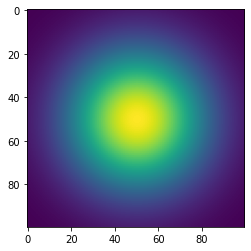

In [124]:
x = np.arange(100)
xx, yy = np.meshgrid(x, x)
img = exp((-(xx-50)**2 - (yy-50)**2)/1000)
# plt.figure(figsize=(14, 14))
plt.imshow(img)

In [125]:
xm = xx + np.random.randn(*xx.shape)
ym = yy + np.random.randn(*yy.shape)

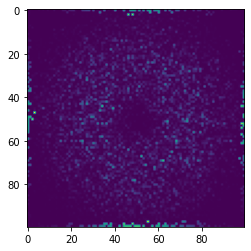

In [126]:
out = image_sample(img, xm, ym)
plt.imshow((out - img)**2)

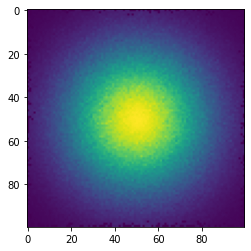

In [127]:
# plt.figure(figsize=(14, 14))
plt.imshow(out)

# Create some vessels
In the first part, we will create a straight vessel and create lambdas for each pixel

In [266]:
def create_straight_vessel(img_size=32, vessel_thickness=5, rotate=0, noise=0.01):
    '''
    Given an image and vessel size, and rotation of vessel
    rotation is in degrees
    '''
    img = np.zeros((img_size, img_size)) + np.random.randn()
    C = img_size // 2
    x = np.arange(img_size) - C
    xx, yy = np.meshgrid(x, x)
    # Get angle
    theta = rotate / 180 * pi
    sint = sin(theta)
    cost = cos(theta)
    # Get distance of each point from 
    dist = np.abs(sint*xx - cost*yy)
    vessel = (dist < vessel_thickness//2).astype(int)
    # Find vessel directions
    vx = cost + vessel*0
    vy = sint + vessel*0
    # find distance of each point
    r = vessel * 0
    for B in [C, -C]:
        # Same for x
        scale = (B - xx)/vx
        yt = yy + vy*scale
        idx = (-C <= yt)&(yt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[idx][idr] + 0
       
        # Same for y
        scale = (B - yy)/vy
        xt = xx + vx*scale
        idx = (-C <= xt)&(xt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[idx][idr] + 0      
    
    r = r
    # find perpendicular distance
    scale = np.abs(np.abs(dist) - vessel_thickness//2)
    vx1 = -vy*scale
    vy1 = vx*scale 
    # generate flows
    flowparallel = np.concatenate([vx[...,None], vy[..., None]], -1)
    flowper = np.concatenate([vx1[...,None], vy1[..., None]], -1)    
    
    return vessel, flowparallel, flowper, r
    

In [296]:
vessel, fparallel, fper, r = create_straight_vessel(50, vessel_thickness=5, rotate=30)

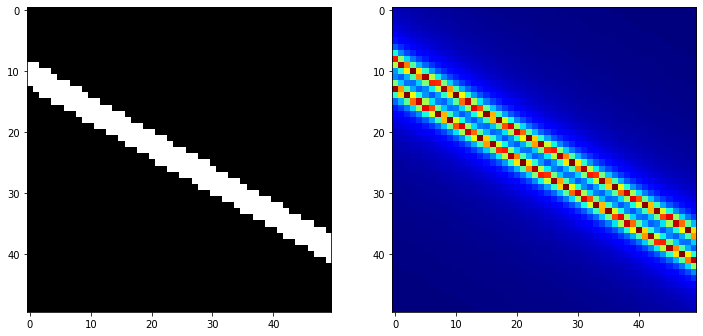

In [297]:
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(vessel, 'gray')
plt.subplot(122)
# plt.imshow(1./(1 + fper**2).sum(-1)) 1 / lambda_parallel  + 1./lam_per
plt.imshow(1./np.sqrt((1e-1 + fper**2).sum(-1)) + 1./np.sqrt((1e-1 + fparallel**2).sum(-1)), 'jet')

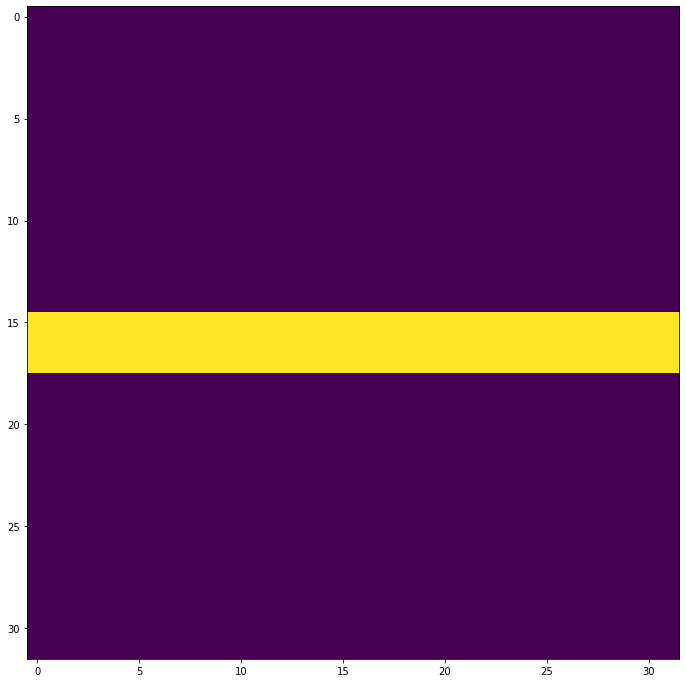

In [270]:
plt.figure(figsize=(12, 12))
plt.imshow(vessel)